In [1]:
import os 
import re

In [2]:
f = open('../classical/main_local_solver-copy.html', 'r')

In [3]:
maxcuts = {}
name = ""
for line in f.readlines():
    if 'graph' in line:
        name = line.strip()
    if 'MaxCut' in line:
        maxcuts[name] = int(re.sub('[^0-9]','', line))

In [4]:
import sys
import os, glob
sys.path.insert(0, os.path.abspath('../'))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.embedding.chain_strength import uniform_torque_compensation
import dwave.inspector
from shared.graph_helper import generate_butterfly_graph,draw_graph, load_nx_graph_from, load_graphs
from shared.QiskitMaxcut import Maxcut

%matplotlib inline

DIVIDER_LENGTH = 115

In [6]:
results = {}

In [7]:
def run_qubo_with(max_cut, print_to_user=False):
    """ Run Experiments with D-WAVE """

    # ------- Run our QUBO on the QPU -------
    # Set up QPU parameters
    chain_strength = partial(uniform_torque_compensation, prefactor=2)
    num_reads = 1000
    Q = max_cut.calculate_Q_matrix()

    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler())
    response = sampler.sample_qubo(Q,
                                   chain_strength=chain_strength,
                                   num_reads=num_reads,
                                   label='QUBO {}'.format(max_cut.graph.name))

    # Inspect
    # dwave.inspector.show(response)

    # ------- Calculate distribution -------
    distribution = {}
    mean = sum([r[1] * r[2] for r in response.record]) / num_reads   
    
    most_sampled_bitstring_with_lowest_energy = ([],0, 0)
    
    for sample, E, occ, cbf in response.data(fields=['sample', 'energy', 'num_occurrences', 'chain_break_fraction']):
        if int(E) in distribution:
            distribution[int(E)] += occ
        else:
            distribution[int(E)] = occ

        
        if most_sampled_bitstring_with_lowest_energy[1] >= E:
            if most_sampled_bitstring_with_lowest_energy[2] <= occ:
                most_sampled_bitstring_with_lowest_energy = (sample.values(), E, occ)
            
            
    distribution_nn = distribution.copy()
    for e, o in distribution.items():
        if distribution[e] == 0:
            distribution_nn.pop(e)
            
    approx_ratio = mean / max_cut.opt_max_cut
    max_energy = np.max(list(distribution_nn.keys()))
    min_energy = np.min(list(distribution_nn.keys()))
    if (mean - max_energy) != 0 and (min_energy - max_energy)!= 0 : 
        ratio = (mean - max_energy) / (min_energy - max_energy)
    else:
        ratio = 0
        
    #results[name] = (mean, ratio, approx_ratio)

    if print_to_user:
    
        # ------- Plot results to user -------
        plt.clf()
        plt.bar(distribution_nn.keys(), distribution_nn.values())  # density=False would make counts
        plt.ylabel('Solution Occurrences')
        plt.xlabel('Energy')
        plt.title(f"Expectation Value (Ø: {mean:.3f})")
        plt.show()

        print(f'Highest Energy: {max_energy:.3f}')
        print(f'Lowest Energy: {min_energy:.3f}')
        print(f'Mean: {mean:.3f}')
        print(f'Approximation Ratio: {approx_ratio:.3f}')
        print(f'Ratio r: {ratio:.3f}')
        best_bitstring = np.array(list(most_sampled_bitstring_with_lowest_energy[0]))
        print(f"Most sampled solution BitString (with lowest energy): {best_bitstring}")


        # ------- Draw cut graph to user -------
        plt.clf()
        max_cut.draw(best_bitstring)
        plt.show()

    # ------- Print results to user -------
    if print_to_user:
        print('Additional Information:')
        print('ID: {:>15s}'.format(str(response.info['problem_id'])))
        print('Chain strength: {:>5s}'.format(str(response.info['embedding_context']['chain_strength'])))

        print()
        print('{:>15s}{:>15s}{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}'.format('Set 0', 'Set 1', 'Energy', 'Cut Size', 'Occurrences', 'Bitstring', 'Chain Break Fraction'))
        print('-' * DIVIDER_LENGTH)
        for sample, E, occ, cbf in response.data(fields=['sample', 'energy', 'num_occurrences', 'chain_break_fraction']):
            S0 = [k for k, v in sample.items() if v == 0]
            S1 = [k for k, v in sample.items() if v == 1]
            print('{:>15s}{:>15s}{:^15s}{:^15s}{:^15s}{:^15s}{:^15s}'.format(str(S0), str(S1), str(E), str(int(-1 * E)), str(occ), ", ".join(map(str, sample.values())), str(cbf)))

        print('-' * DIVIDER_LENGTH)
    
    return mean, ratio, approx_ratio

In [8]:
def calculate_maxcut_for(graph):
    print('-' * DIVIDER_LENGTH)
    print(f"Running filename: {graph.name}")
    plt.clf()
    draw_graph(graph)
    plt.show()

    means = []
    rs = []
    ars = []
    
    for _ in range(0,5):
        opt_max_cut = maxcuts[graph.name]
        max_cut = Maxcut(graph, -opt_max_cut)
        m, r, ar = run_qubo_with(max_cut)
        means.append(m)
        if r != 0:
            rs.append(r)
        ars.append(ar)
        
    results[graph.name] = (np.median(means), np.median(rs), np.median(ars))
    print(f"Optimal MaxCut: {-opt_max_cut}, Expectation Value: {m:.3f}, Ratio r: {r:.3f}, Approx. Ratio: {ar:.3f}")
        

In [9]:
def run_all():
    for file in sorted(glob.glob("entire_data/*.txt")):
        graph = load_nx_graph_from(file)
        calculate_maxcut_for(graph)

-------------------------------------------------------------------------------------------------------------------
Running filename: graph_04_06_01


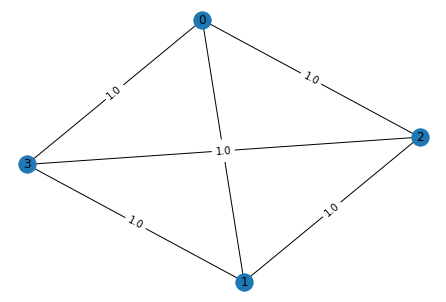

Optimal MaxCut: -4, Expectation Value: -4.000, Ratio r: 0.000, Approx. Ratio: 1.000
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_04_06_01_w


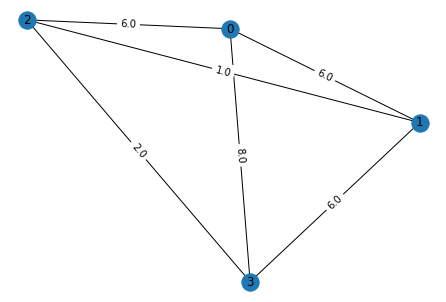

Optimal MaxCut: -21, Expectation Value: -20.627, Ratio r: 0.925, Approx. Ratio: 0.982
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_05_06_02


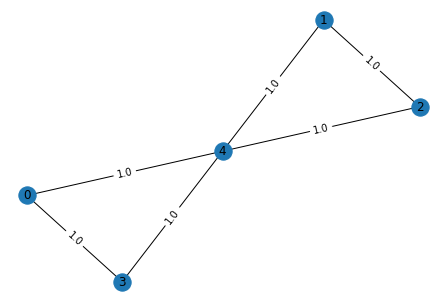

Optimal MaxCut: -4, Expectation Value: -4.000, Ratio r: 0.000, Approx. Ratio: 1.000
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_05_06_02_w


/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


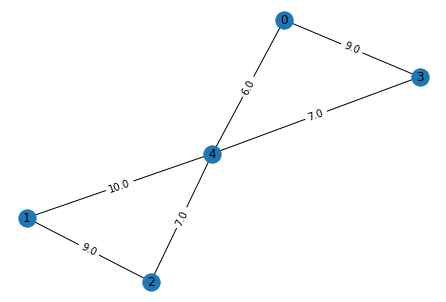

Optimal MaxCut: -35, Expectation Value: -34.335, Ratio r: 0.889, Approx. Ratio: 0.981
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_06_14_01


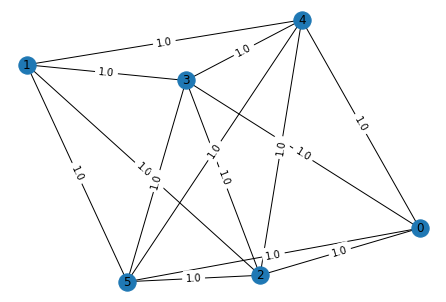

Optimal MaxCut: -9, Expectation Value: -8.754, Ratio r: 0.877, Approx. Ratio: 0.973
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_06_14_01_w


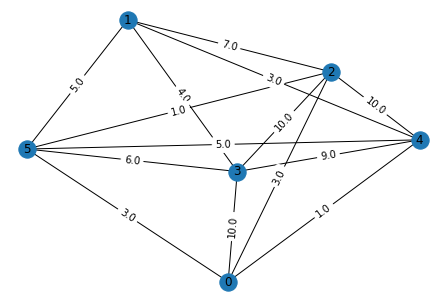

Optimal MaxCut: -56, Expectation Value: -53.055, Ratio r: 0.836, Approx. Ratio: 0.947
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_07_15_01


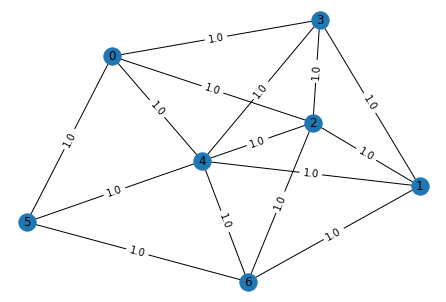

Optimal MaxCut: -10, Expectation Value: -9.873, Ratio r: 0.958, Approx. Ratio: 0.987
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_07_15_01_w


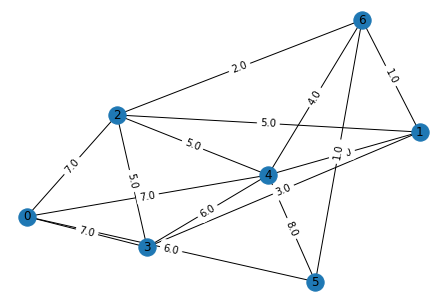

Optimal MaxCut: -52, Expectation Value: -50.647, Ratio r: 0.903, Approx. Ratio: 0.974
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_08_20_01


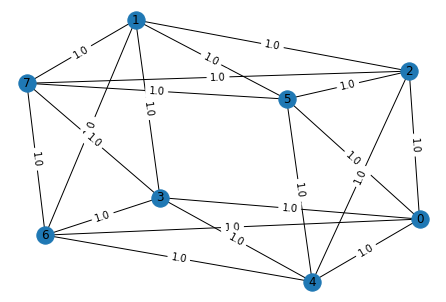

Optimal MaxCut: -16, Expectation Value: -16.000, Ratio r: 0.000, Approx. Ratio: 1.000
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_08_20_01_w


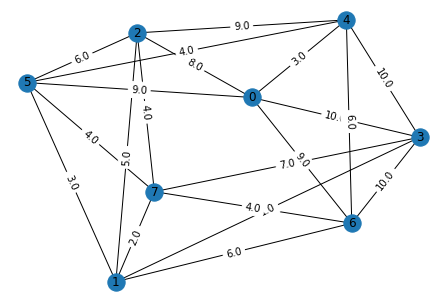

Optimal MaxCut: -99, Expectation Value: -98.987, Ratio r: 0.999, Approx. Ratio: 1.000
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_09_28_01


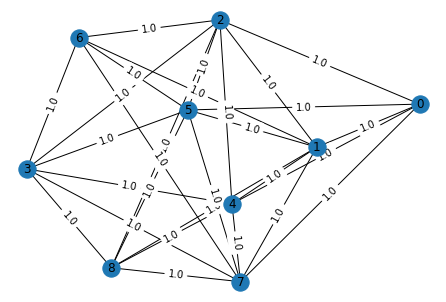

Optimal MaxCut: -19, Expectation Value: -18.248, Ratio r: 0.850, Approx. Ratio: 0.960
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_09_28_01_w


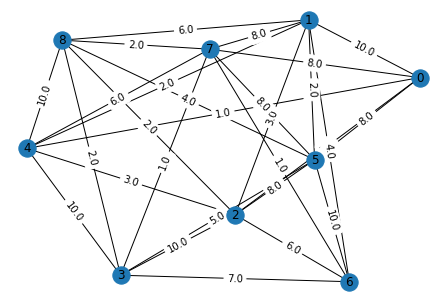

Optimal MaxCut: -115, Expectation Value: -108.578, Ratio r: 0.786, Approx. Ratio: 0.944
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_10_31_01


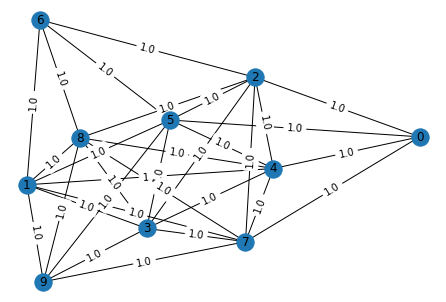

Optimal MaxCut: -21, Expectation Value: -19.772, Ratio r: 0.795, Approx. Ratio: 0.942
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_10_31_01_w


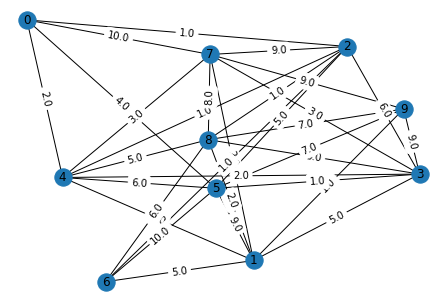

Optimal MaxCut: -117, Expectation Value: -112.956, Ratio r: 0.856, Approx. Ratio: 0.965
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_11_37_01


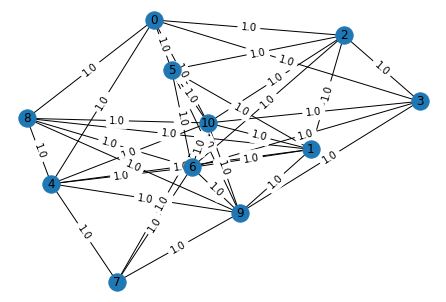

Optimal MaxCut: -26, Expectation Value: -24.690, Ratio r: 0.813, Approx. Ratio: 0.950
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_11_37_01_w


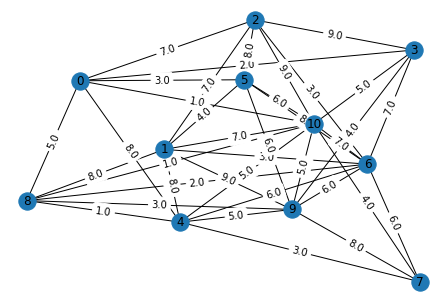

Optimal MaxCut: -141, Expectation Value: -135.531, Ratio r: 0.848, Approx. Ratio: 0.961
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_12_40_01


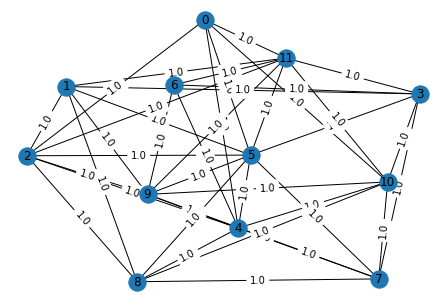

Optimal MaxCut: -29, Expectation Value: -27.778, Ratio r: 0.825, Approx. Ratio: 0.958
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_12_40_01_w


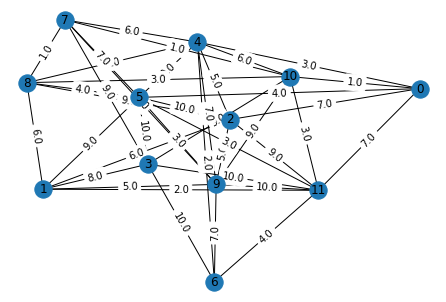

Optimal MaxCut: -174, Expectation Value: -165.795, Ratio r: 0.790, Approx. Ratio: 0.953
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_13_52_01


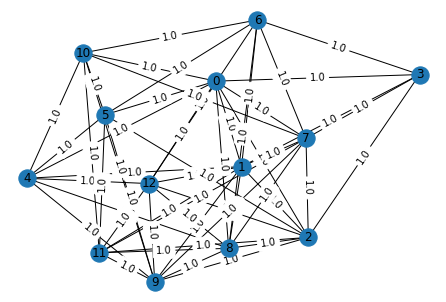

Optimal MaxCut: -37, Expectation Value: -36.081, Ratio r: 0.885, Approx. Ratio: 0.975
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_13_52_01_w


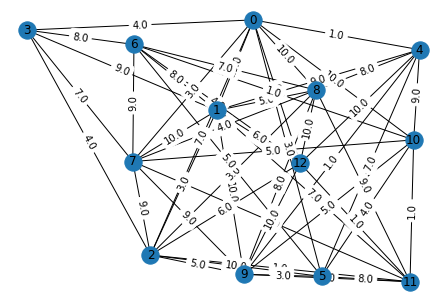

Optimal MaxCut: -242, Expectation Value: -236.793, Ratio r: 0.925, Approx. Ratio: 0.978
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_14_54_02


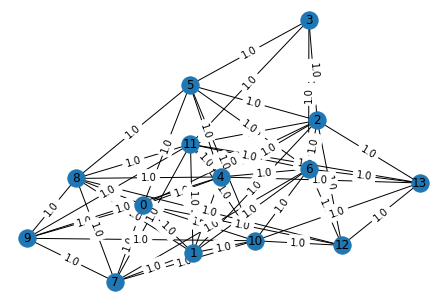

Optimal MaxCut: -37, Expectation Value: -35.249, Ratio r: 0.750, Approx. Ratio: 0.953
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_14_54_02_w


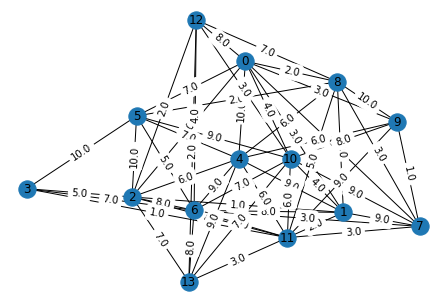

Optimal MaxCut: -219, Expectation Value: -209.045, Ratio r: 0.822, Approx. Ratio: 0.955
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_15_61_01


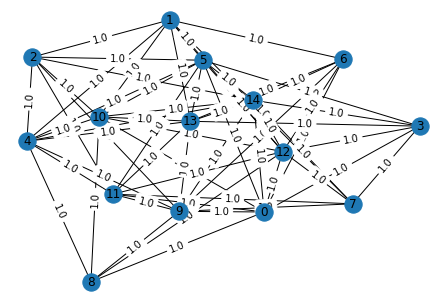

Optimal MaxCut: -42, Expectation Value: -40.678, Ratio r: 0.811, Approx. Ratio: 0.969
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_15_61_01_w


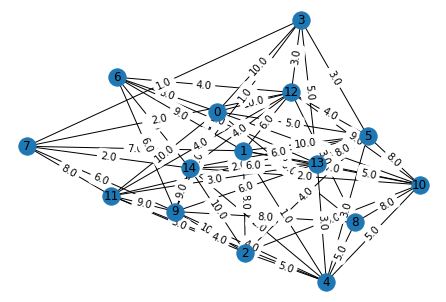

Optimal MaxCut: -238, Expectation Value: -227.739, Ratio r: 0.791, Approx. Ratio: 0.957
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_16_65_01


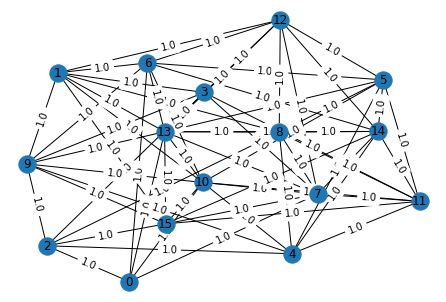

Optimal MaxCut: -44, Expectation Value: -42.256, Ratio r: 0.751, Approx. Ratio: 0.960
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_16_65_01_w


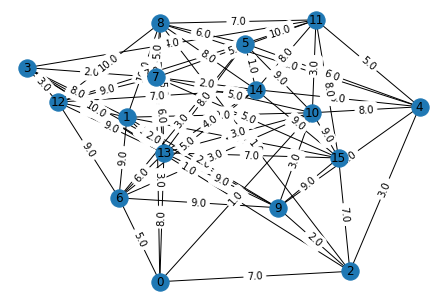

Optimal MaxCut: -271, Expectation Value: -257.485, Ratio r: 0.795, Approx. Ratio: 0.950
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_17_77_01


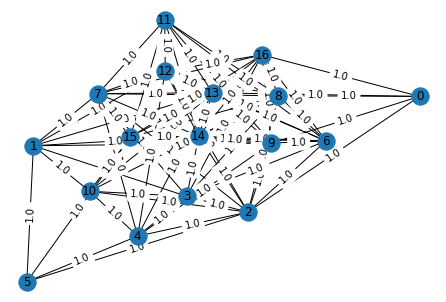

Optimal MaxCut: -54, Expectation Value: -51.885, Ratio r: 0.788, Approx. Ratio: 0.961
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_17_77_01_w


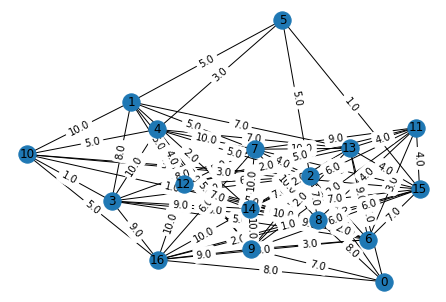

Optimal MaxCut: -320, Expectation Value: -306.831, Ratio r: 0.803, Approx. Ratio: 0.959
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_18_105_01


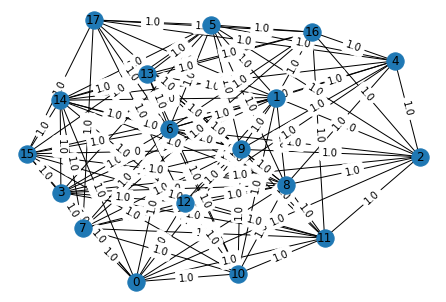

Optimal MaxCut: -65, Expectation Value: -61.827, Ratio r: 0.683, Approx. Ratio: 0.951
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_18_105_01_w


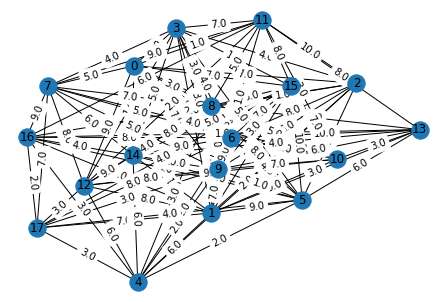

Optimal MaxCut: -392, Expectation Value: -368.355, Ratio r: 0.689, Approx. Ratio: 0.940
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_19_98_01


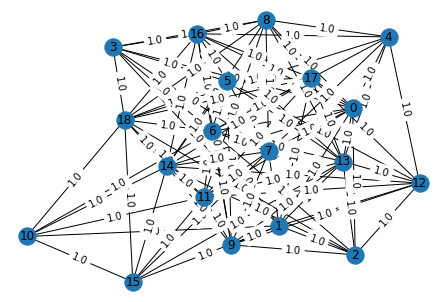

Optimal MaxCut: -64, Expectation Value: -61.291, Ratio r: 0.754, Approx. Ratio: 0.958
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_19_98_01_w


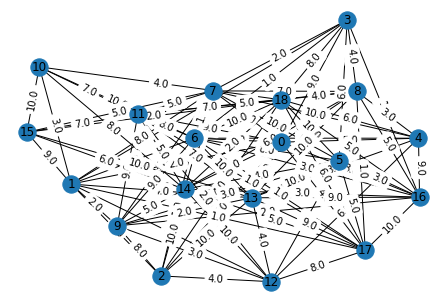

Optimal MaxCut: -391, Expectation Value: -371.513, Ratio r: 0.747, Approx. Ratio: 0.950
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_20_109_01


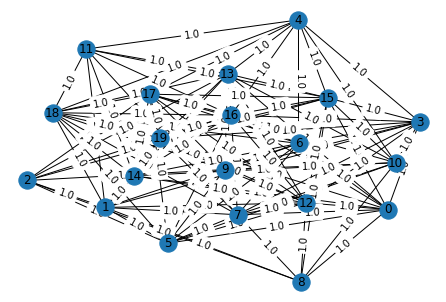

Optimal MaxCut: -72, Expectation Value: -69.287, Ratio r: 0.791, Approx. Ratio: 0.962
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_20_109_01_w


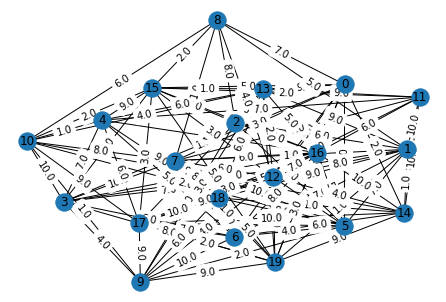

Optimal MaxCut: -412, Expectation Value: -395.298, Ratio r: 0.804, Approx. Ratio: 0.959
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_21_129_01


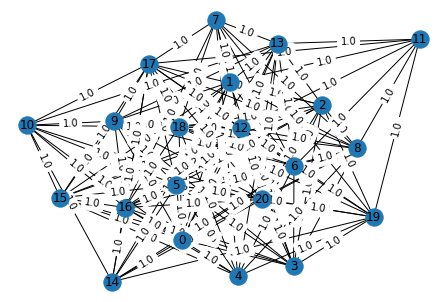

Optimal MaxCut: -83, Expectation Value: -78.588, Ratio r: 0.724, Approx. Ratio: 0.947
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_21_129_01_w


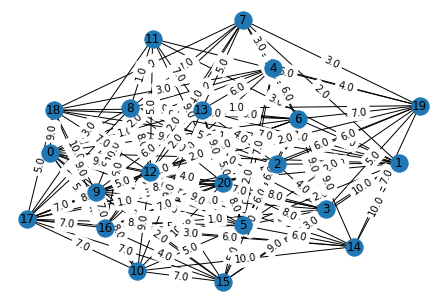

Optimal MaxCut: -459, Expectation Value: -437.135, Ratio r: 0.712, Approx. Ratio: 0.952
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_22_128_01


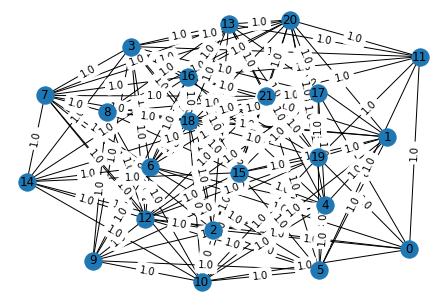

Optimal MaxCut: -84, Expectation Value: -79.135, Ratio r: 0.696, Approx. Ratio: 0.942
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_22_128_01_w


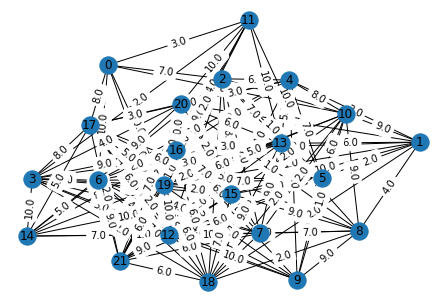

Optimal MaxCut: -475, Expectation Value: -449.892, Ratio r: 0.701, Approx. Ratio: 0.947
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_23_134_01


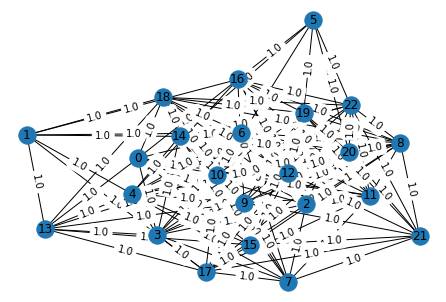

Optimal MaxCut: -85, Expectation Value: -81.670, Ratio r: 0.723, Approx. Ratio: 0.961
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_23_134_01_w


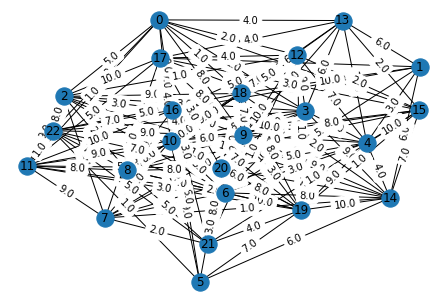

Optimal MaxCut: -498, Expectation Value: -471.972, Ratio r: 0.671, Approx. Ratio: 0.948
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_24_146_01


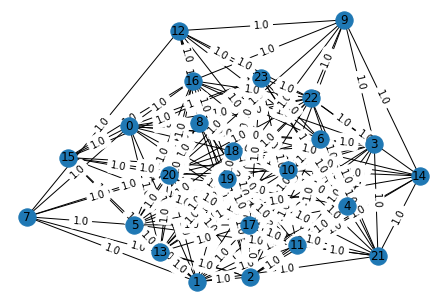

Optimal MaxCut: -97, Expectation Value: -92.773, Ratio r: 0.718, Approx. Ratio: 0.956
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_24_146_01_w


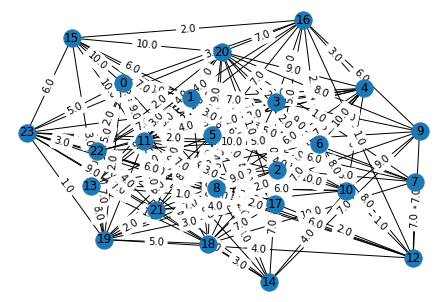

Optimal MaxCut: -556, Expectation Value: -520.234, Ratio r: 0.656, Approx. Ratio: 0.936
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_25_168_01


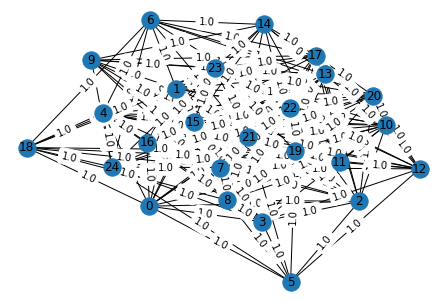

Optimal MaxCut: -108, Expectation Value: -103.269, Ratio r: 0.722, Approx. Ratio: 0.956
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_25_168_01_w


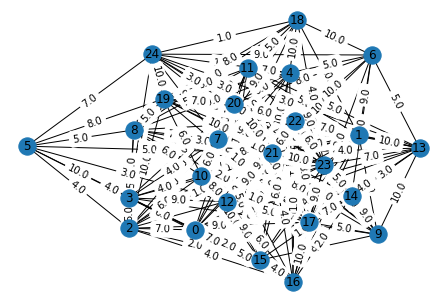

Optimal MaxCut: -634, Expectation Value: -595.291, Ratio r: 0.624, Approx. Ratio: 0.939
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_26_182_01


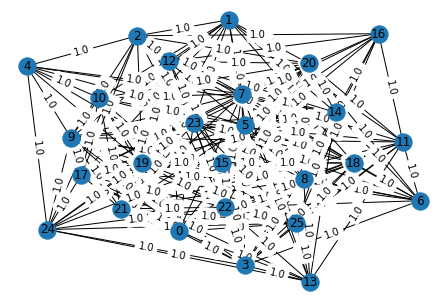

Optimal MaxCut: -114, Expectation Value: -107.679, Ratio r: 0.579, Approx. Ratio: 0.945
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_26_182_01_w


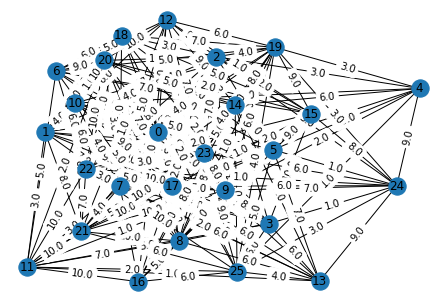

Optimal MaxCut: -684, Expectation Value: -642.225, Ratio r: 0.646, Approx. Ratio: 0.939
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_27_207_01


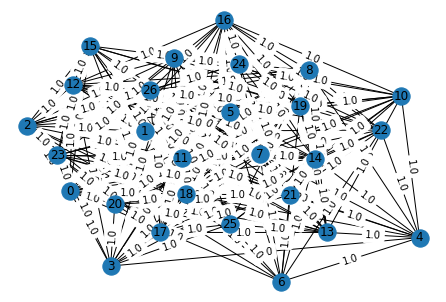

Optimal MaxCut: -130, Expectation Value: -121.756, Ratio r: 0.607, Approx. Ratio: 0.937
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_27_207_01_w


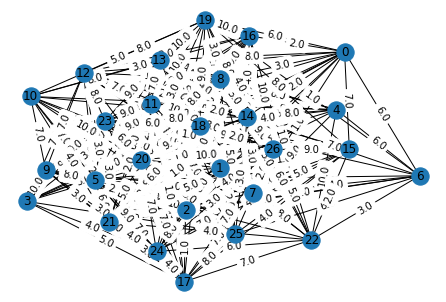

Optimal MaxCut: -713, Expectation Value: -676.784, Ratio r: 0.690, Approx. Ratio: 0.949
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_28_217_01


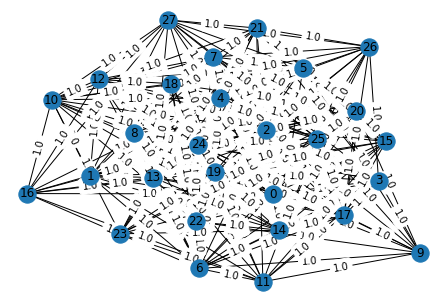

Optimal MaxCut: -137, Expectation Value: -128.513, Ratio r: 0.631, Approx. Ratio: 0.938
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_28_217_01_w


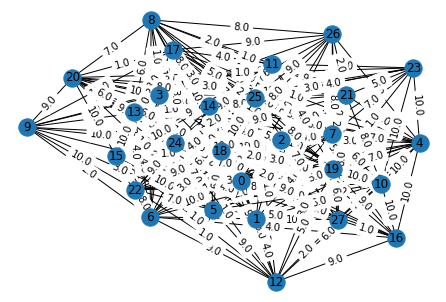

Optimal MaxCut: -830, Expectation Value: -771.302, Ratio r: 0.565, Approx. Ratio: 0.929
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_29_232_01


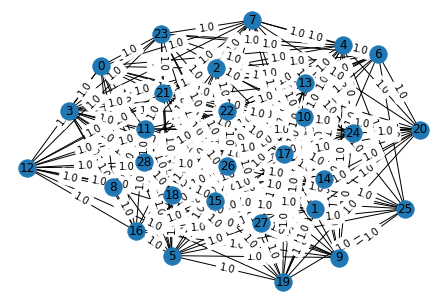

Optimal MaxCut: -144, Expectation Value: -136.229, Ratio r: 0.647, Approx. Ratio: 0.946
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_29_232_01_w


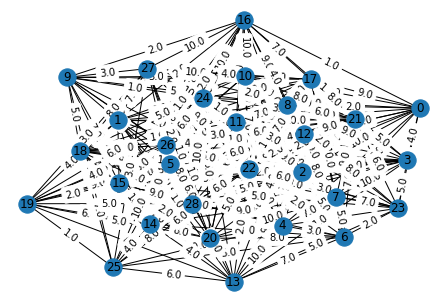

Optimal MaxCut: -854, Expectation Value: -795.885, Ratio r: 0.582, Approx. Ratio: 0.932
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_30_234_01


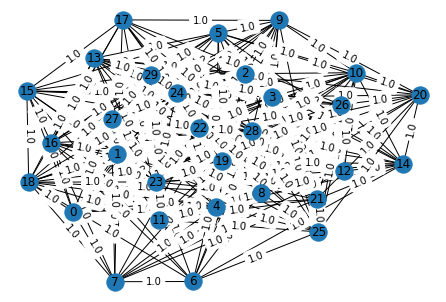

Optimal MaxCut: -149, Expectation Value: -139.418, Ratio r: 0.583, Approx. Ratio: 0.936
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_30_234_01_w


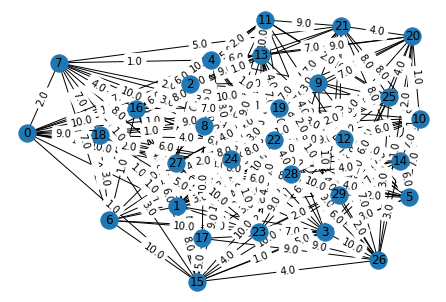

Optimal MaxCut: -818, Expectation Value: -765.751, Ratio r: 0.679, Approx. Ratio: 0.936
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_31_265_01


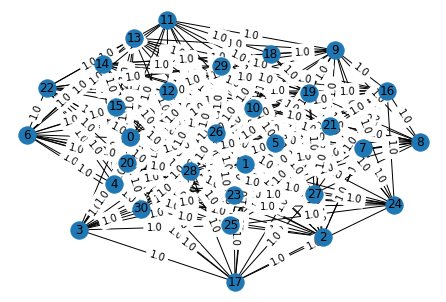

Optimal MaxCut: -164, Expectation Value: -155.493, Ratio r: 0.646, Approx. Ratio: 0.948
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_31_265_01_w


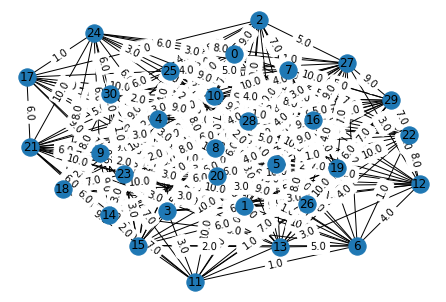

Optimal MaxCut: -978, Expectation Value: -913.283, Ratio r: 0.603, Approx. Ratio: 0.934
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_32_263_01


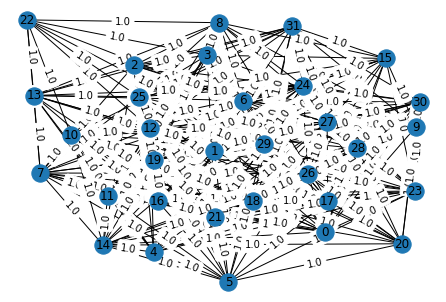

Optimal MaxCut: -166, Expectation Value: -155.866, Ratio r: 0.673, Approx. Ratio: 0.939
-------------------------------------------------------------------------------------------------------------------
Running filename: graph_32_263_01_w


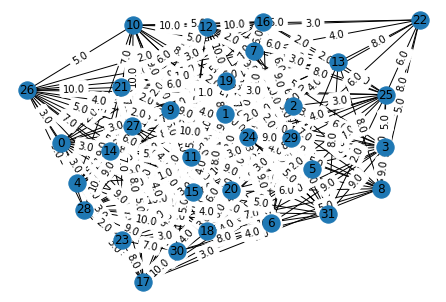

Optimal MaxCut: -949, Expectation Value: -886.439, Ratio r: 0.569, Approx. Ratio: 0.934


In [10]:
run_all()

In [11]:
import pickle
def save_dict(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_dict(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
save_dict(results, "entire_data_results_dict")

In [19]:
import pandas as pd

temp = {}
for key in sorted(results.keys()):
    if '_w' in key:
        name = str(int(key.split('_')[1])) + 'w'
    else:
        name = str(int(key.split('_')[1])) 
    temp[name] = results[key]
    
results_df = pd.DataFrame.from_dict(temp, orient='index', columns=['Expectation Value', 'Ratio r', 'Approximation Ratio'])
results_df

Expectation Value   Ratio r  Approximation Ratio
4               -4.000  0.999000             1.000000
4w             -20.635  0.929000             0.982619
5               -4.000       NaN             1.000000
5w             -34.335  0.889167             0.981000
6               -8.762  0.881000             0.973556
6w             -53.417  0.848059             0.953875
7               -9.870  0.953667             0.987000
7w             -50.664  0.919588             0.974308
8              -16.000  0.998000             1.000000
8w             -98.960  0.998216             0.999596
9              -18.248  0.841600             0.960421
9w            -109.207  0.818594             0.949626
10             -19.849  0.769800             0.945190
10w           -112.778  0.875235             0.963915
11             -24.828  0.822000             0.954923
11w           -135.531  0.838394             0.961213
12             -27.754  0.822000             0.957034
12w           -165.892  0.789947             0.953402
13             -35.889  0.876556             0.969973
13w           -236.793  0.921429             0.978483
14             -35.257  0.787000             0.952892
14w           -208.940  0.785364             0.954064
15             -40.678  0.840444             0.968524
15w           -227.739  0.798653             0.956887
16             -42.253  0.776125             0.960295
16w           -256.349  0.742691             0.945937
17             -51.892  0.788500             0.960963
17w           -308.860  0.830821             0.965188
18             -61.827  0.652556             0.951185
18w           -365.246  0.703034             0.931750
19             -61.141  0.735900             0.955328
19w           -372.245  0.746922             0.952033
20             -69.511  0.820200             0.965431
20w           -395.244  0.798120             0.959330
21             -78.588  0.698667             0.946843
21w           -437.135  0.715857             0.952364
22             -79.153  0.681643             0.942298
22w           -453.297  0.756977             0.954309
23             -81.637  0.754571             0.960435
23w           -473.394  0.681135             0.950590
24             -92.049  0.699944             0.948959
24w           -520.234  0.656096             0.935673
25            -102.890  0.716111             0.952685
25w           -597.291  0.663220             0.942099
26            -107.679  0.624118             0.944553
26w           -642.225  0.646934             0.938925
27            -121.756  0.627348             0.936585
27w           -677.956  0.709361             0.950850
28            -128.239  0.596714             0.936051
28w           -774.266  0.608167             0.932851
29            -136.428  0.646773             0.947417
29w           -797.620  0.618042             0.933981
30            -140.158  0.618565             0.940658
30w           -765.751  0.655105             0.936126
31            -155.411  0.642125             0.947628
31w           -909.894  0.608489             0.930362
32            -155.629  0.617484             0.937524
32w           -883.323  0.568545             0.930793

<AxesSubplot:xlabel='Nodes', ylabel='Approximation Ratio'>

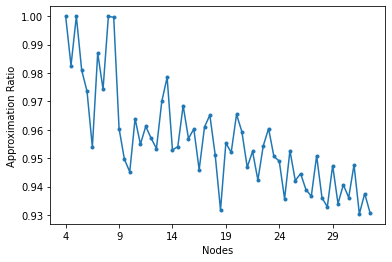

In [21]:
results_df.iloc[:,2].plot(marker='.', ylabel="Approximation Ratio", xlabel="Nodes")